In [197]:
!pip install umap-learn --quiet
!pip install trimap --quiet
!pip install pacmap --quiet

In [198]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.manifold import TSNE
import umap
import trimap
import pacmap
import matplotlib.pyplot as plt

In [199]:
data = pd.read_csv("echocardiogram.csv").dropna()

# with pd.option_context("display.max_rows", 1000):
#     display(data)

data

,survival,alive,age,pericardialeffusion,fractionalshortening,epss,lvdd,wallmotion-score,wallmotion-index,mult,name,group,aliveat1
0,11.00,0.0,71.0,0.0,0.260,9.000,4.600,14.00,1.00,1.000,name,1,0.0
1,19.00,0.0,72.0,0.0,0.380,6.000,4.100,14.00,1.70,0.588,name,1,0.0
2,16.00,0.0,55.0,0.0,0.260,4.000,3.420,14.00,1.00,1.000,name,1,0.0
3,57.00,0.0,60.0,0.0,0.253,12.062,4.603,16.00,1.45,0.788,name,1,0.0
4,19.00,1.0,57.0,0.0,0.160,22.000,5.750,18.00,2.25,0.571,name,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,1.25,1.0,63.0,0.0,0.300,6.900,3.520,18.16,1.51,0.857,name,2,1.0
106,24.00,0.0,59.0,0.0,0.170,14.300,5.490,13.50,1.50,0.643,name,2,0.0
107,25.00,0.0,57.0,0.0,0.228,9.700,4.290,11.00,1.00,0.786,name,2,0.0
109,0.75,1.0,78.0,0.0,0.230,40.000,6.230,14.00,1.40,0.714,name,2,1.0


In [200]:
# target_columns = ['survival', 'alive', 'aliveat1']
target_columns = ['alive']
feature_columns = [
    'survival', 'aliveat1',
    'age', 'pericardialeffusion', 'fractionalshortening',
    'epss', 'lvdd', 'wallmotion-score', 'wallmotion-index', 'mult'
]

X = data[feature_columns]
y = data[target_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [201]:
def calculate_metrics(y_true, y_pred, label):
    print(f"{label} Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"{label} Recall: {recall_score(y_true, y_pred, average='weighted')}")
    print(f"{label} Precision: {precision_score(y_true, y_pred, average='weighted')}")
    print(f"{label} F1 Score: {f1_score(y_true, y_pred, average='weighted')}")
    print()

In [202]:
def plot_embedding(method, X, y, support_vectors, title):
    X = np.array(X)
    y = np.array(y)
    embedding = method.fit_transform(X)
    data_points = embedding
    if support_vectors[0]:
      support_vectors_points = embedding[support_vectors]
    plt.figure(figsize=(10, 8))
    plt.scatter(data_points[:, 0], data_points[:, 1], c=y, alpha=0.6, label='Data points')
    if support_vectors[0]:
      plt.scatter(support_vectors_points[:, 0], support_vectors_points[:, 1], marker='x', s=100, color='red', label='Support Vectors')
    plt.title(title)
    plt.legend()
    plt.show()

In [203]:
def plot_comparison(method, X, y_true, y_pred, title):
    embedding = method.fit_transform(X)

    # Истинные метки классов
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=np.array(y_true), alpha=0.6, label='True Labels')
    plt.title(f'{title} - True Labels')

    # Предсказанные метки классов
    plt.subplot(1, 2, 2)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=np.array(y_pred), alpha=0.6, label='Predicted Labels')
    plt.title(f'{title} - Predicted Labels')

    plt.show()

**SVM-классификатор**

In [204]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

svm = SVC()
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train.values.ravel())

best_svm = grid_search.best_estimator_

In [205]:
y_train_pred = best_svm.predict(X_train)
y_test_pred = best_svm.predict(X_test)

calculate_metrics(y_train, y_train_pred, "Train")
calculate_metrics(y_test, y_test_pred, "Test")

print("Число опорных векторов:", best_svm.n_support_)

Train Accuracy: 0.9523809523809523
Train Recall: 0.9523809523809523
Train Precision: 0.9523809523809523
Train F1 Score: 0.9523809523809523

Test Accuracy: 0.9473684210526315
Test Recall: 0.9473684210526315
Test Precision: 0.9548872180451128
Test F1 Score: 0.9483400809716599

Число опорных векторов: [9 6]


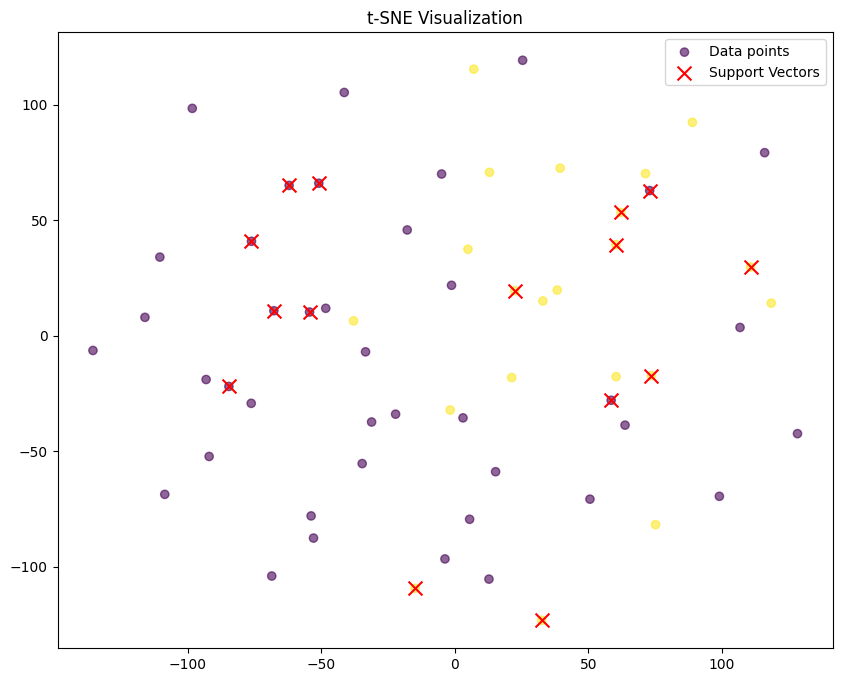

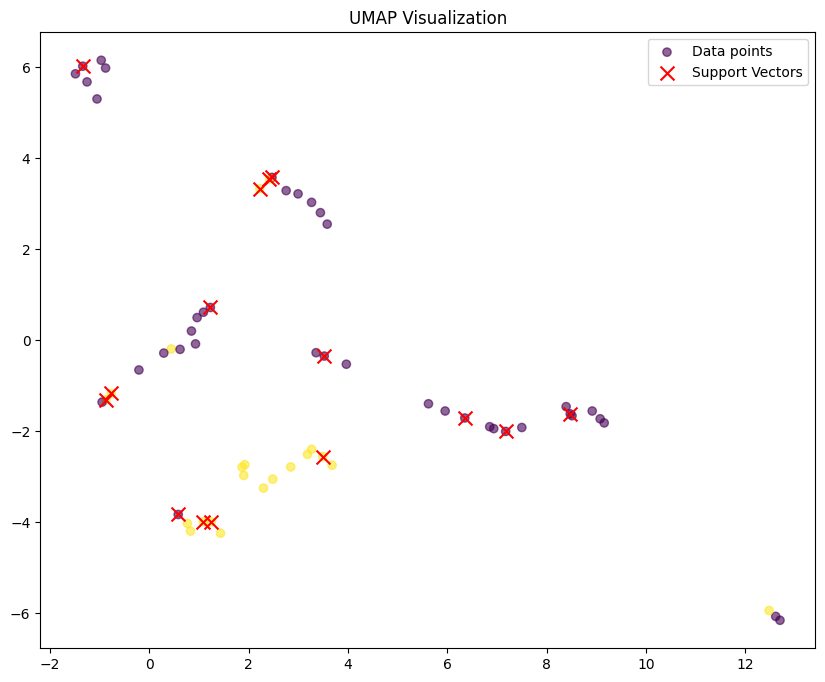

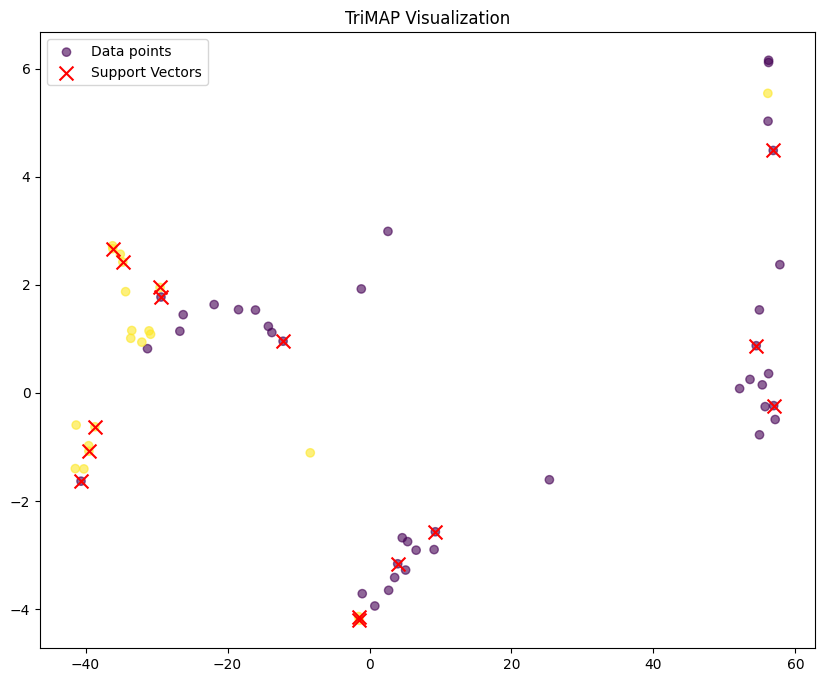

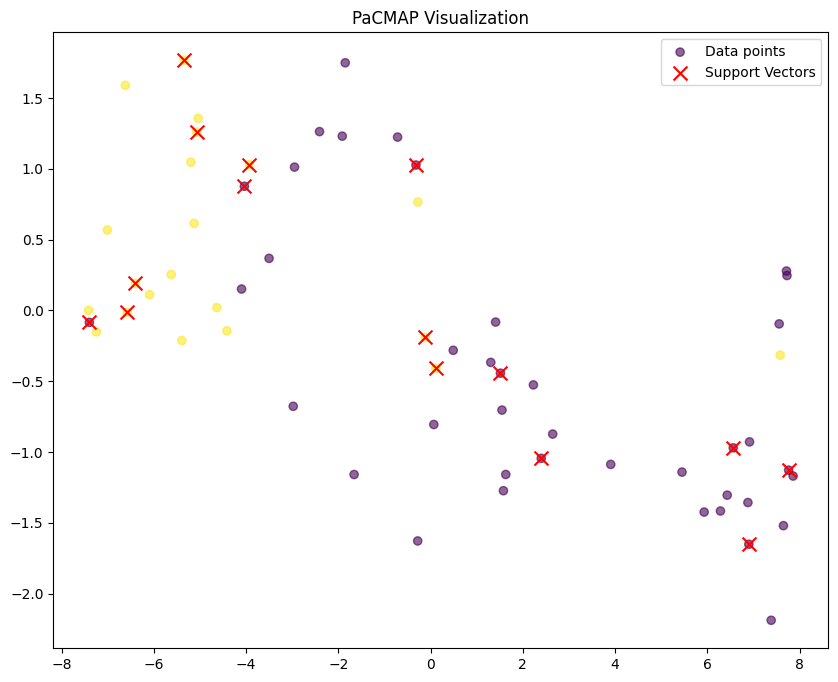

In [206]:
support_vectors = best_svm.support_

tsne = TSNE(n_components=3)
plot_embedding(tsne, X, y, support_vectors, 't-SNE Visualization')

umap_model = umap.UMAP(n_neighbors=3)
plot_embedding(umap_model, X, y, support_vectors, 'UMAP Visualization')

trimap_model = trimap.TRIMAP(n_inliers=10, n_outliers=10, n_random=20)
plot_embedding(trimap_model, X, y, support_vectors, 'TriMAP Visualization')

pacmap_model = pacmap.PaCMAP(n_neighbors=10)
plot_embedding(pacmap_model, X, y, support_vectors, 'PaCMAP Visualization')

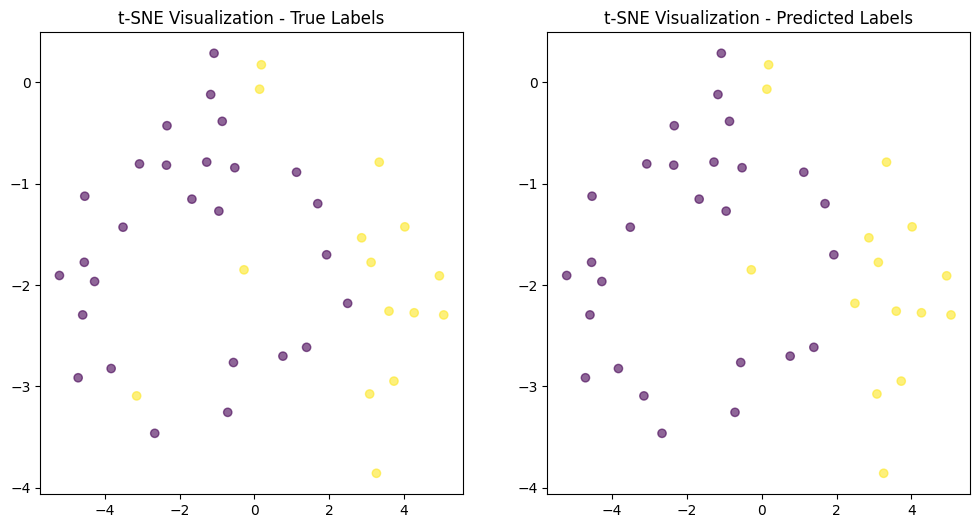

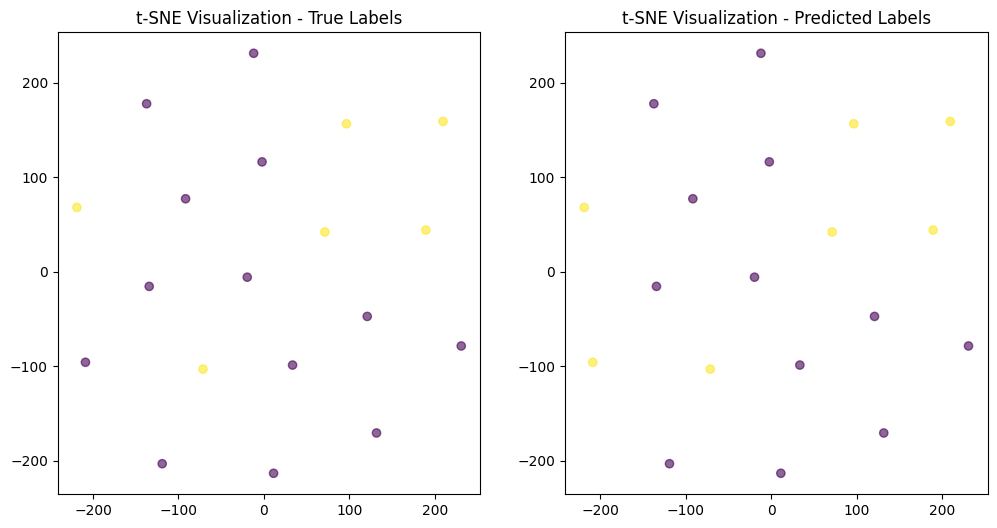

In [207]:
tsne = TSNE(n_components=2, perplexity=18)
plot_comparison(tsne, X_train, y_train, y_train_pred, 't-SNE Visualization')
plot_comparison(tsne, X_test, y_test, y_test_pred, 't-SNE Visualization')

**knn-классификатор**

In [216]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train.values.ravel())

best_knn = grid_search.best_estimator_

In [209]:
y_train_pred = best_knn.predict(X_train)
y_test_pred = best_knn.predict(X_test)

calculate_metrics(y_train, y_train_pred, "Train")
calculate_metrics(y_test, y_test_pred, "Test")

Train Accuracy: 1.0
Train Recall: 1.0
Train Precision: 1.0
Train F1 Score: 1.0

Test Accuracy: 0.8947368421052632
Test Recall: 0.8947368421052632
Test Precision: 0.9210526315789473
Test F1 Score: 0.8978696741854637



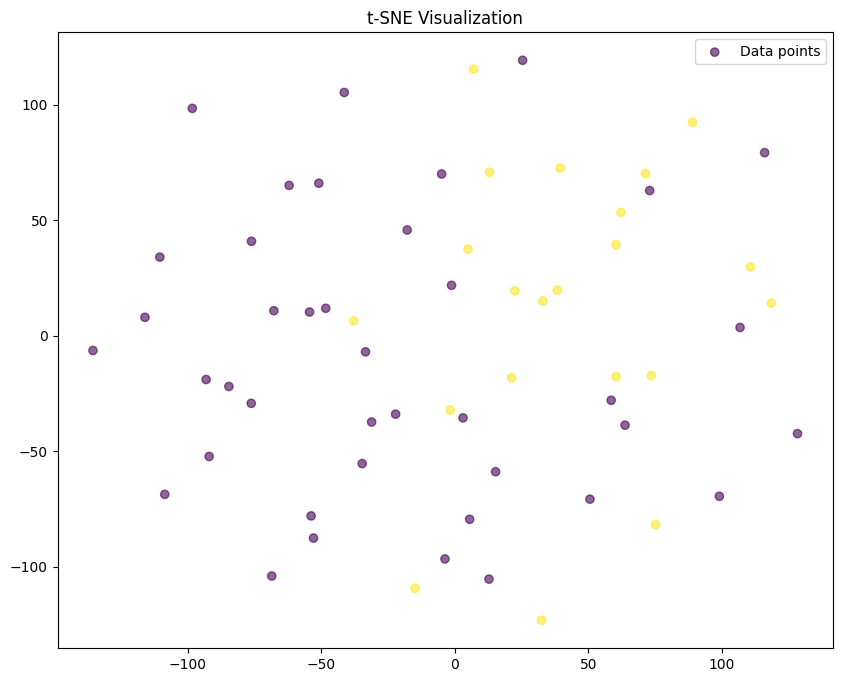

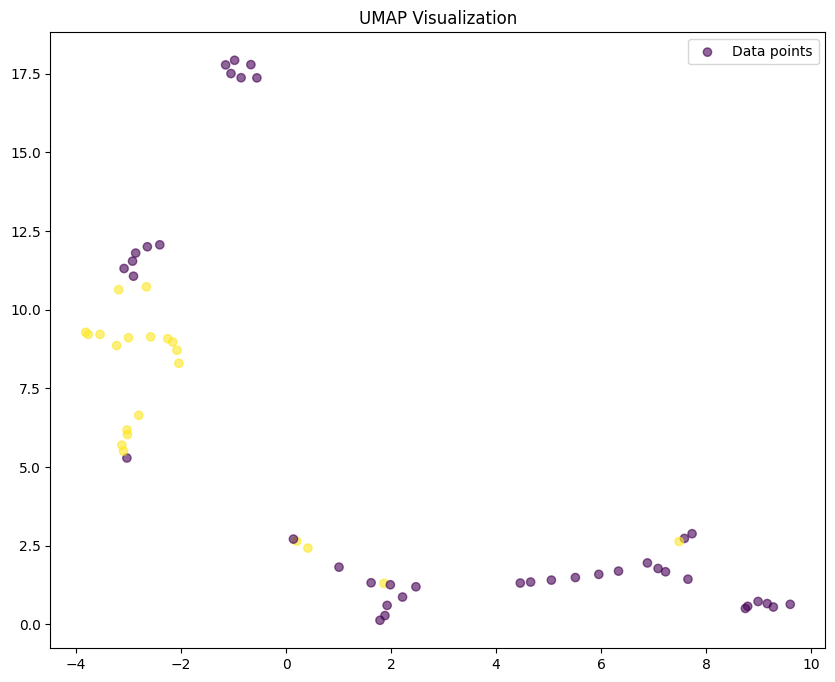

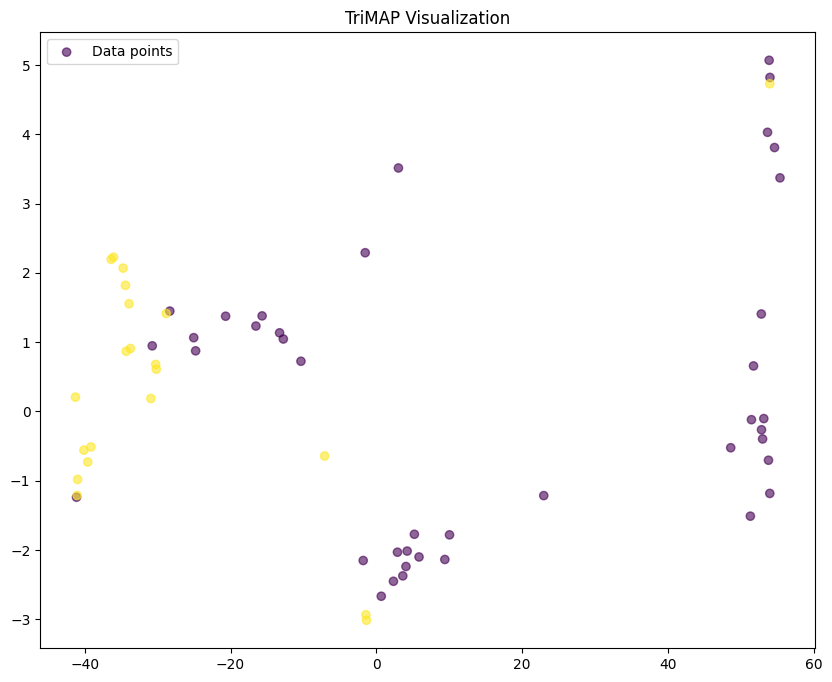

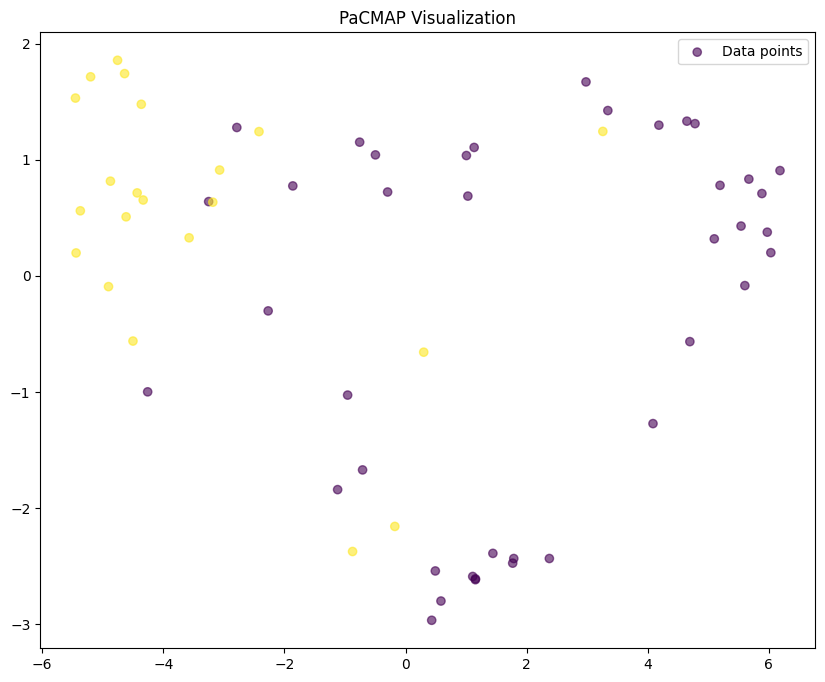

In [210]:
support_vectors = [None]

tsne = TSNE(n_components=3)
plot_embedding(tsne, X, y, support_vectors, 't-SNE Visualization')

umap_model = umap.UMAP(n_neighbors=3)
plot_embedding(umap_model, X, y, support_vectors, 'UMAP Visualization')

trimap_model = trimap.TRIMAP(n_inliers=10, n_outliers=10, n_random=20)
plot_embedding(trimap_model, X, y, support_vectors, 'TriMAP Visualization')

pacmap_model = pacmap.PaCMAP(n_neighbors=10)
plot_embedding(pacmap_model, X, y, support_vectors, 'PaCMAP Visualization')

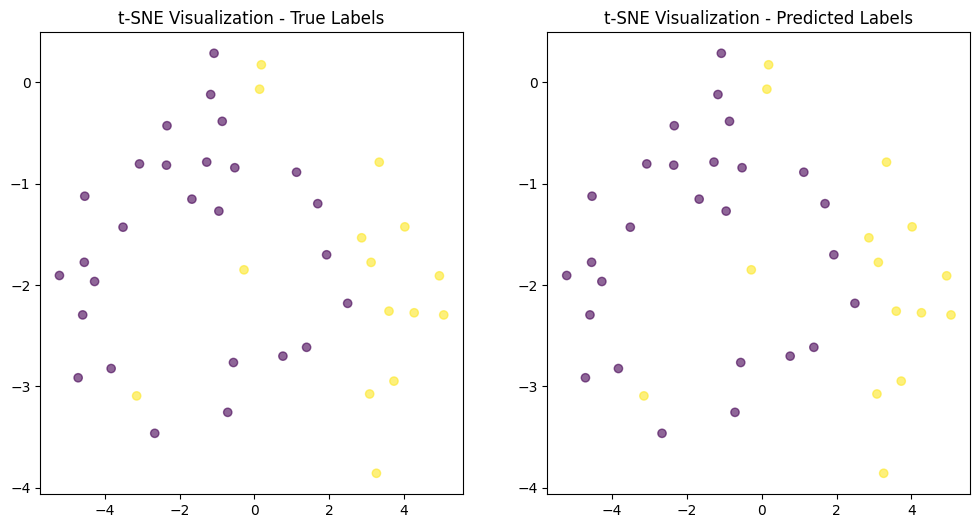

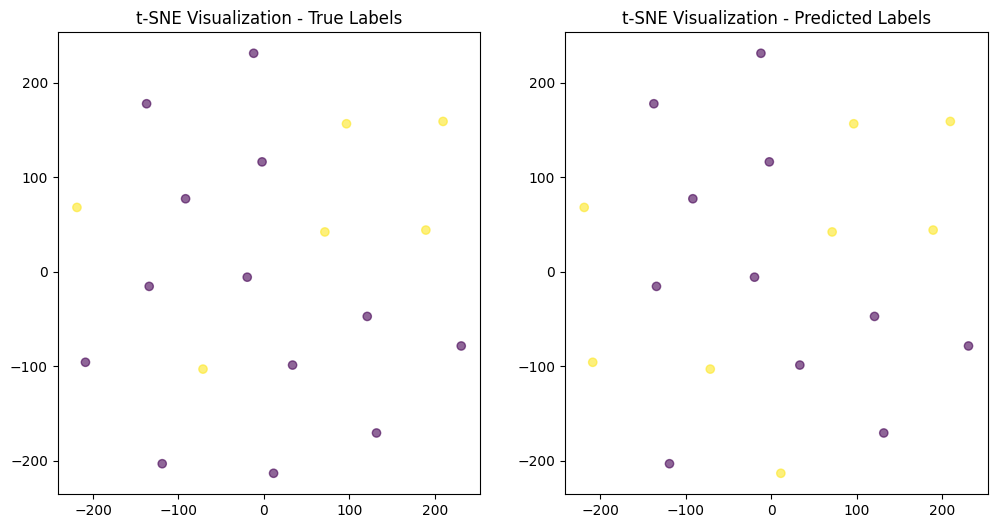

In [211]:
tsne = TSNE(n_components=2, perplexity=18)
plot_comparison(tsne, X_train, y_train, y_train_pred, 't-SNE Visualization')
plot_comparison(tsne, X_test, y_test, y_test_pred, 't-SNE Visualization')

**RF-классификатор**

In [212]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train.values.ravel())

best_rf = grid_search.best_estimator_

In [213]:
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

calculate_metrics(y_train, y_train_pred, "Train")
calculate_metrics(y_test, y_test_pred, "Test")

Train Accuracy: 0.9761904761904762
Train Recall: 0.9761904761904762
Train Precision: 0.9770408163265306
Train F1 Score: 0.9759964173757277

Test Accuracy: 0.9473684210526315
Test Recall: 0.9473684210526315
Test Precision: 0.9548872180451128
Test F1 Score: 0.9483400809716599



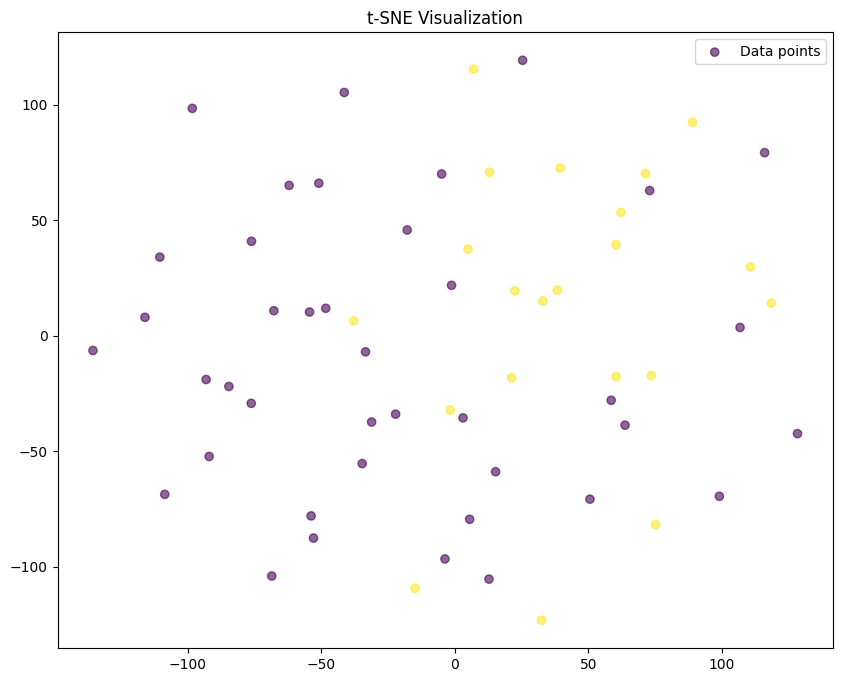

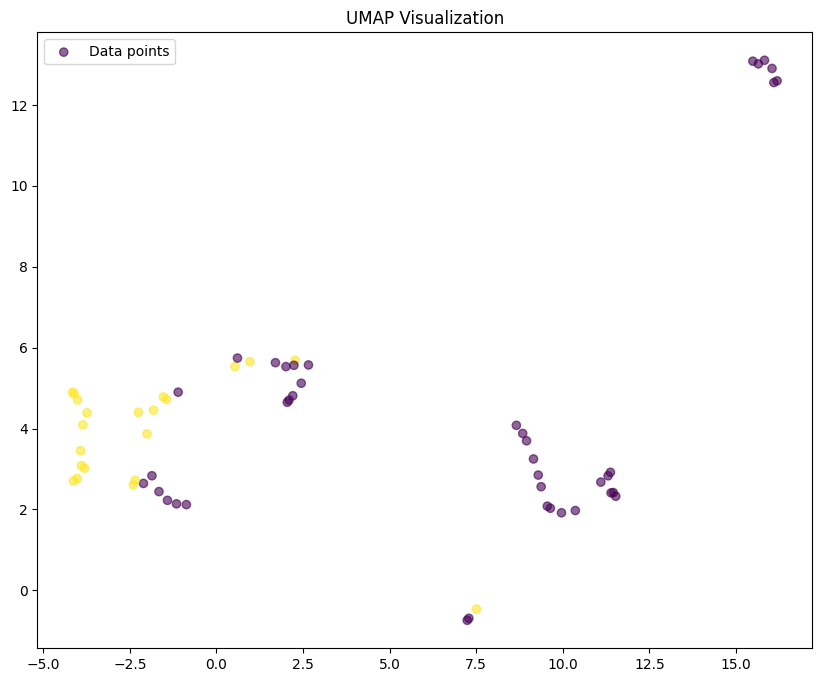

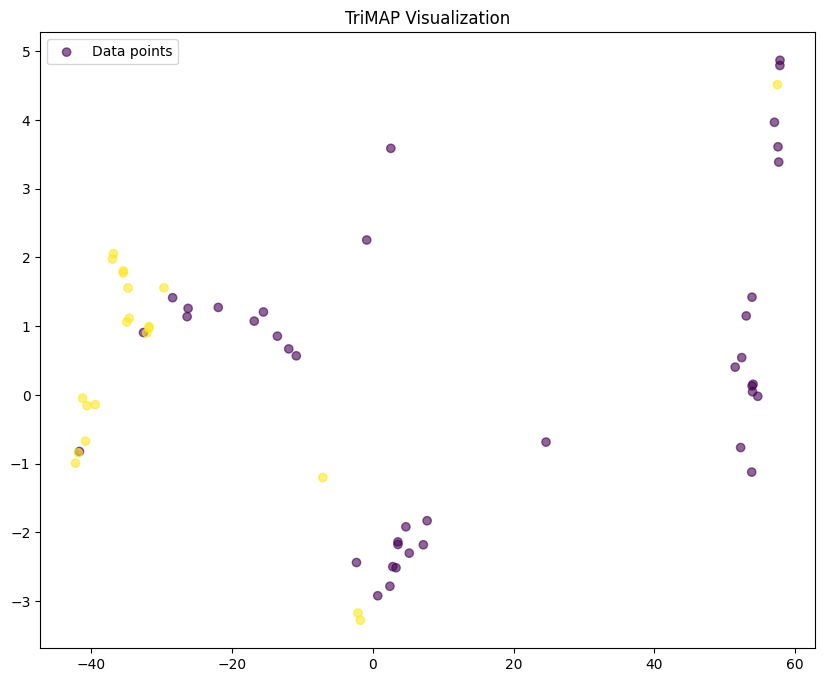

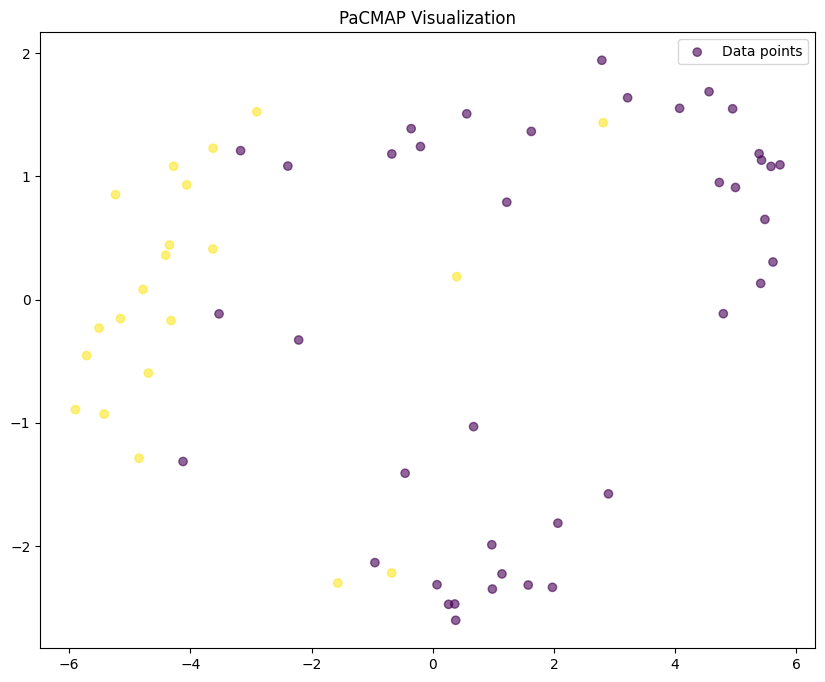

In [214]:
support_vectors = [None]

tsne = TSNE(n_components=3)
plot_embedding(tsne, X, y, support_vectors, 't-SNE Visualization')

umap_model = umap.UMAP(n_neighbors=3)
plot_embedding(umap_model, X, y, support_vectors, 'UMAP Visualization')

trimap_model = trimap.TRIMAP(n_inliers=10, n_outliers=10, n_random=20)
plot_embedding(trimap_model, X, y, support_vectors, 'TriMAP Visualization')

pacmap_model = pacmap.PaCMAP(n_neighbors=10)
plot_embedding(pacmap_model, X, y, support_vectors, 'PaCMAP Visualization')

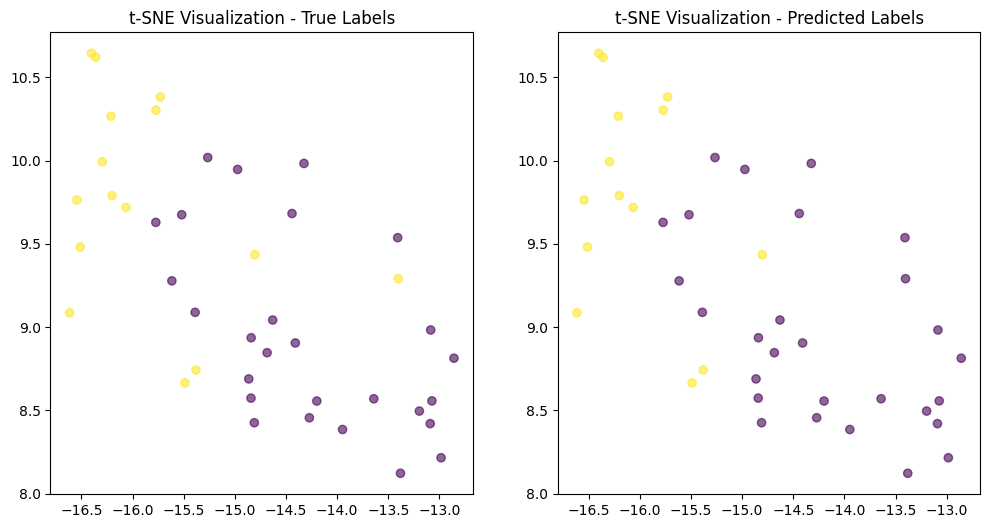

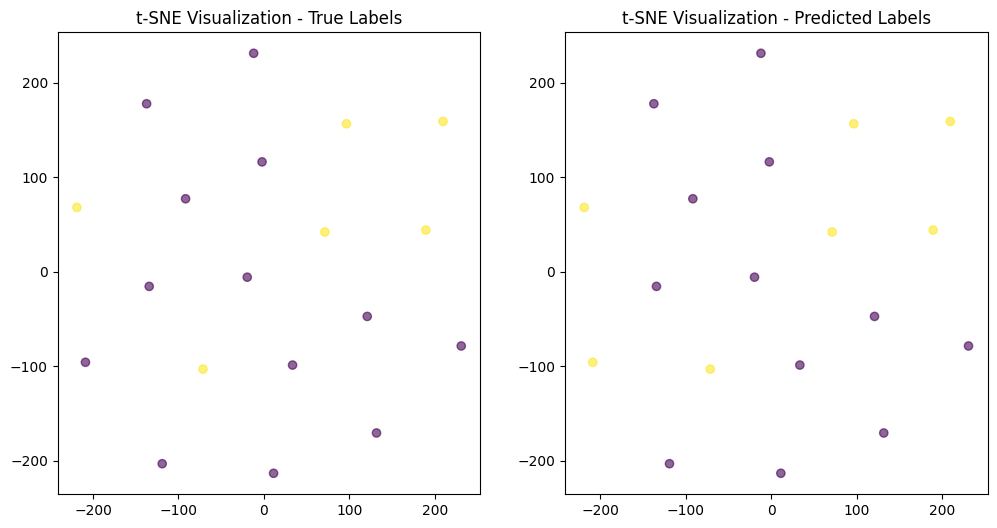

In [215]:
tsne = TSNE(n_components=2)
plot_comparison(tsne, X_train, y_train, y_train_pred, 't-SNE Visualization')
tsne = TSNE(n_components=2, perplexity=18)
plot_comparison(tsne, X_test, y_test, y_test_pred, 't-SNE Visualization')